In [1]:
# Note this analysis is based on a project that was done as part of the MISD program

# Import a bunch of libraries.
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_mldata
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.grid_search import GridSearchCV

import matplotlib
import decimal
from scipy import stats

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

C:\Users\tyu\Anaconda3\envs\ipykernel_py2\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\tyu\Anaconda3\envs\ipykernel_py2\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [4]:
# Importing the data

mnist = fetch_mldata('MNIST (original)', data_home='~/datasets/mnist')
X, Y = mnist.data, mnist.target

# Rescale grayscale values to [0,1].
X = X / 255.0

# Shuffle the input so each run will re-shuffle the data, resulting in a different ordering.
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

print 'data shape: ', X.shape
print 'label shape:', Y.shape

# Set some variables to hold test, dev, and training data.
test_data, test_labels = X[61000:], Y[61000:]
dev_data, dev_labels = X[60000:61000], Y[60000:61000]
train_data, train_labels = X[:60000], Y[:60000]
mini_train_data, mini_train_labels = X[:1000], Y[:1000]

data shape:  (70000L, 784L)
label shape: (70000L,)


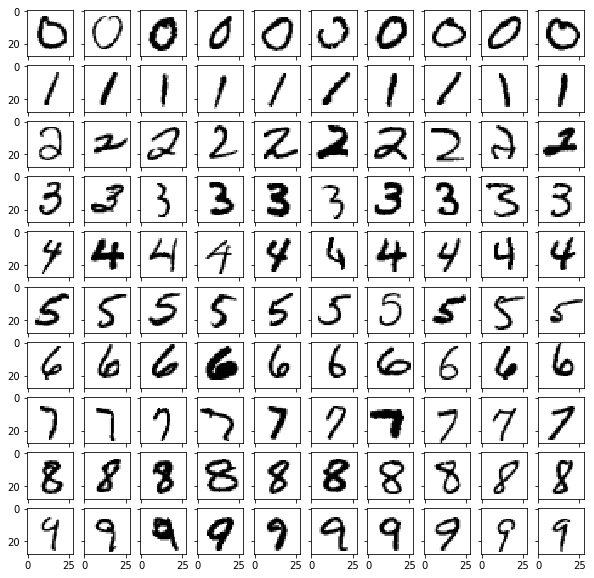

In [5]:
# Printing a sample of the numbers

number_samples = {}

for index,label in enumerate(mini_train_labels):
    if label not in number_samples:
        number_samples[label] = []
    else:
        if len(number_samples[label]) < 10:
            number_samples[label].append(index)
        else:
            continue 

# Plotting the image of the sample numbers collected above. 
            
f, axarr = plt.subplots(10, 10, figsize=(10,10), sharex=True, sharey=True)
            
for i, values in number_samples.items():
    for j, index in enumerate(values):
        digit = mini_train_data[index].reshape(28,28)
        axarr[int(i), int(j)].imshow(digit, cmap = matplotlib.cm.binary)

In [6]:
# Training and modeling with mini set and then reporting accuracy for dev set.

k_values = [1, 3, 5, 7, 9]
outcomes = {}
cls_reports = {}

for k in k_values:
    cls = KNeighborsClassifier(n_neighbors=k)
    cls.fit(mini_train_data, mini_train_labels)
    
    predictions = cls.predict(dev_data)
    accuracy = accuracy_score(dev_labels, predictions)
    outcomes[k] = accuracy
    cls_reports[k] = classification_report(dev_labels, predictions)

print outcomes
print "\nIt seems like k=1 is the best result on the dev set after training on the mini set.\n"
    
# Showing the precision, recall, and F1 for each label.

print cls_reports[1]

{1: 0.892, 3: 0.876, 9: 0.86, 5: 0.867, 7: 0.871}

It seems like k=1 is the best result on the dev set after training on the mini set.

             precision    recall  f1-score   support

        0.0       0.93      0.97      0.95        91
        1.0       0.90      0.98      0.94       133
        2.0       0.94      0.91      0.93       111
        3.0       0.85      0.90      0.88        98
        4.0       0.92      0.87      0.89       107
        5.0       0.83      0.76      0.79        78
        6.0       0.94      0.93      0.94       101
        7.0       0.91      0.92      0.91        98
        8.0       0.93      0.79      0.86        97
        9.0       0.75      0.83      0.78        86

avg / total       0.89      0.89      0.89      1000



In [7]:
train_sizes = [100, 200, 400, 800, 1600, 3200, 6400, 12800, 25000]
time2train = {}
outcomes = {}

# Looking at the accuracy and training time for k=1

for train_size in train_sizes:
    train_data_temp = train_data[:train_size]
    train_labels_temp = train_labels[:train_size]
    
    cls = KNeighborsClassifier(n_neighbors=1)
    
    start = time.time()
    cls.fit(train_data_temp, train_labels_temp)
    stop = time.time()
    
    time2train[train_size] =  round(stop - start,5)
    
    predictions = cls.predict(dev_data)
    accuracy = accuracy_score(dev_labels, predictions)
    outcomes[train_size] = accuracy   

# Reporting the accuracy and time results  
    
print "The below are the times it took to train with the different training sizes: "
print time2train

print "The below are the accuracies with the different training sizes: "
print outcomes

The below are the times it took to train with the different training sizes: 
{1600: 0.038, 3200: 0.114, 100: 0.002, 200: 0.003, 6400: 0.308, 400: 0.005, 25000: 4.747, 12800: 1.062, 800: 0.017}
The below are the accuracies with the different training sizes: 
{1600: 0.902, 3200: 0.931, 100: 0.704, 200: 0.791, 6400: 0.941, 400: 0.849, 25000: 0.964, 12800: 0.954, 800: 0.87}


[[1.23373742]]
[[1.03360546]]


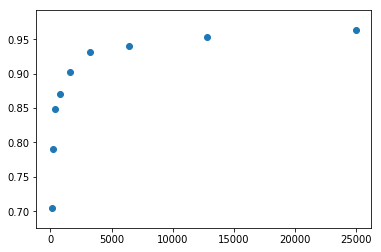

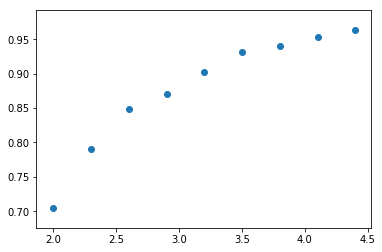

In [8]:
# Allocating the result of the previous section into appropriate variables and reporting the prediction. 

size_val = [x[0] for x in sorted(outcomes.items())]
accuracy_val = [x[1] for x in sorted(outcomes.items())]

# Graphing the linear relationship between size and accuracy. 

fig1, ax1 = plt.subplots()
ax1.scatter(size_val, accuracy_val)

cls = LinearRegression()
X = np.array(size_val).reshape(-1,1)
Y = np.array(accuracy_val).reshape(-1,1)

cls.fit(X,Y)
print cls.predict(60000)

# Log transforming the independent variable and remodeling the data. 

fig2, ax2 = plt.subplots()
ax2.scatter(np.log10(size_val), accuracy_val)

cls2 = LinearRegression()
X2 = np.array(np.log10(size_val)).reshape(-1,1)
Y2 = np.array(accuracy_val).reshape(-1,1)

cls.fit(X2,Y2)
print cls.predict(np.log10(60000))

Confusion Matrix:
[[ 91   0   0   0   0   0   0   0   0   0]
 [  0 132   1   0   0   0   0   0   0   0]
 [  1   0 109   1   0   0   0   0   0   0]
 [  0   0   0  95   0   1   0   1   1   0]
 [  0   0   0   0 103   0   0   0   0   4]
 [  0   0   0   0   1  76   0   0   0   1]
 [  0   2   0   0   0   0  99   0   0   0]
 [  0   1   0   0   0   0   0  97   0   0]
 [  0   2   0   1   1   3   1   0  89   0]
 [  1   1   0   0   1   0   0   1   0  82]]
[14, 60, 64, 88, 109]


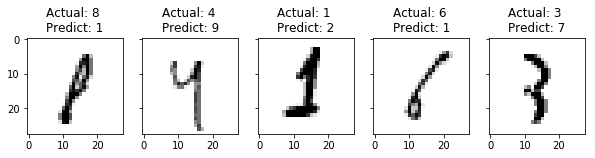

In [9]:
# Training the data 
cls = KNeighborsClassifier(n_neighbors=1)
    
cls.fit(train_data, train_labels)
predictions = cls.predict(dev_data)

# Making confusion matrix to see mistakes of prediction

print "Confusion Matrix:"
print confusion_matrix(dev_labels, predictions)

# Finding unmatched values and plotting 5 of them:

mistakes = []
number_mistakes = 5
    
for index, (true_val, pred_val) in enumerate(zip(dev_labels, predictions)):
    if true_val != pred_val and len(mistakes) < number_mistakes:
        mistakes.append(index)

print mistakes

f, axarr = plt.subplots(1, number_mistakes, figsize=(10,10), sharex=True, sharey=True)
col = 0
            
for i in mistakes:
    digit = dev_data[i].reshape(28,28)
    axarr[col].imshow(digit, cmap = matplotlib.cm.binary)
    axarr[col].set_title('Actual: %d \nPredict: %d' % (dev_labels[i],predictions[i]))
    
    col += 1 
        

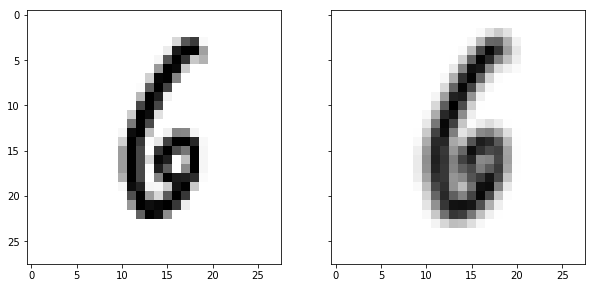

In [10]:
# Defining the blurring functions to try it out. Blurring based on Gaussian blur found here: https://en.wikipedia.org/wiki/Kernel_(image_processing)

def find_weight(a,b):
    if abs(a) == 1 and abs(b) == 1:
        return 1
    elif a == 0 and b ==0:
        return 4
    else:
        return 2

def blurring(image_vector):
    transformed_vector = image_vector.reshape(28,28)
    
    blurred_vector = np.zeros((28,28))
    
    positions = [(-1,-1), (-1,0), (-1,1), (0,-1), (0,0), (0,1), (1,-1), (1,0), (1,-1)]
    
    for index_i, row in enumerate(transformed_vector):
        for index_j, col in enumerate(row):
            
            new_pixel = 0
            counter = 0
            
            for (a,b) in positions:
                
                if 27 >= index_i + a >= 0 and 27 >= index_j + b >=0 :
                    new_pixel += transformed_vector[index_i + a, index_j + b] * find_weight(a,b)
                    counter += find_weight(a,b)
                else:
                    continue
                
            blurred_vector[index_i, index_j] = new_pixel/counter
            #print(transformed_vector[index_i, index_j], blurred_vector[index_i, index_j])
    
    return blurred_vector.flatten()


# The below is a test for the above function

test_image = dev_data[0]
test_normal_image = test_image.reshape(28,28)
test_blurred_image = blurring(test_image)
test_blurred_image = test_blurred_image.reshape(28,28)

f, axarr = plt.subplots(1, 2, figsize=(10,10), sharex=True, sharey=True)
axarr[0].imshow(test_normal_image, cmap = matplotlib.cm.binary)
axarr[1].imshow(test_blurred_image, cmap = matplotlib.cm.binary)

In [11]:
# Creating the blurred image sets 

print "Begin blurring."

blur_train = []
blur_dev = []

for v in train_data:
    blur_train.append(blurring(v))
    
for v in dev_data:
    blur_dev.append(blurring(v))
    
print "Finished blurring."

Begin blurring.
Finished blurring.


In [12]:
# Doing the training on blurred and non-blurred sets. 

cls = KNeighborsClassifier(n_neighbors=1)
    
# Train blurred, dev same    
cls.fit(blur_train, train_labels)
predictions = cls.predict(dev_data)
accuracy = accuracy_score(dev_labels, predictions)

print "Training blurred and Dev same resulted in an accuracy of ", accuracy

# Train same, dev blurred    
cls.fit(train_data, train_labels)
predictions = cls.predict(blur_dev)
accuracy = accuracy_score(dev_labels, predictions)

print "Training same and Dev blurred resulted in an accuracy of ", accuracy

# Train blurred, dev blurred    
cls.fit(blur_train, train_labels)
predictions = cls.predict(blur_dev)
accuracy = accuracy_score(dev_labels, predictions)

print "Training blurred and Dev blurred resulted in an accuracy of ", accuracy

Training blurred and Dev same resulted in an accuracy of  0.981
Training same and Dev blurred resulted in an accuracy of  0.968
Training blurred and Dev blurred resulted in an accuracy of  0.981


In [13]:
# Mapping the pixel values to either 0 and 1 to test BernoulliNB algorithm. 
# Also mapped to 0, 1, and 2 to try multimonial algorithm.

for i in range(0,5):
    print(np.amax(mini_train_data[i]), np.amin(mini_train_data[i]))

# A cutoff of 0.5 was decided because the pixel values seem to range from 0 to 1. 
def Bernoulli_trans(v):
    pixel_matrix = np.zeros(v.shape)

    pixel_matrix[(v <= 0.5)] = 0
    pixel_matrix[(v > 0.5)] = 1
    
    return pixel_matrix

# Cutoffs of 0.33 and 0.67 were decided because the pixel values seem to range from 0 to 1. 
def Multinomial_trans(v):
    pixel_matrix = np.zeros(v.shape)

    pixel_matrix[(v <= 0.33)] = 0
    pixel_matrix[(v <= 0.67)&(v>0.33)] = 1
    pixel_matrix[(v > 0.67)] = 2
    
    return pixel_matrix

# Transforming the data
train_data_Bernoulli = []
train_data_Multinomial = []
dev_data_Bernoulli = []
dev_data_Multinomial = []
mini_train_Bernoulli = []
mini_train_Multinomial = []


for v in train_data:
    train_data_Bernoulli.append(Bernoulli_trans(v))
    train_data_Multinomial.append(Multinomial_trans(v))
    
for v in dev_data:
    dev_data_Bernoulli.append(Bernoulli_trans(v))
    dev_data_Multinomial.append(Multinomial_trans(v))

# Training this for use in P8.
for v in mini_train_data:
    mini_train_Bernoulli.append(Bernoulli_trans(v))
    mini_train_Multinomial.append(Multinomial_trans(v))


# Model training, prediction, and reporting on the accuracy 
cls = BernoulliNB()

cls.fit(train_data_Bernoulli, train_labels)
predictions = cls.predict(dev_data_Bernoulli)
accuracy = accuracy_score(dev_labels, predictions)

print "The accuracy using Bernoulli is ", accuracy

cls = MultinomialNB()

cls.fit(train_data_Multinomial, train_labels)
predictions = cls.predict(dev_data_Multinomial)
accuracy = accuracy_score(dev_labels, predictions)

print "The accuracy using Multinomial is ", accuracy

(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
The accuracy using Bernoulli is  0.837
The accuracy using Multinomial is  0.824


In [14]:
# Looks like Bernoulli is better. Going to use gridsearch to find optimal alpha. 
# Training the data

cls = BernoulliNB()
parameters = {'alpha': [0.0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}

grid_obj = GridSearchCV(cls, parameters, scoring=make_scorer(accuracy_score))
grid_obj = grid_obj.fit(train_data_Bernoulli, train_labels)


# Reporting the best paramter
print "The best alpha seems to be: ", grid_obj.best_params_

# Using the trained data to predict the dev data 
cls = grid_obj.best_estimator_

predictions = cls.predict(dev_data_Bernoulli)
accuracy = accuracy_score(dev_labels, predictions)

print "The accuracy seems to be: ", accuracy, " when using the dev data."

C:\Users\tyu\Anaconda3\envs\ipykernel_py2\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


The best alpha seems to be:  {'alpha': 0.0}
The accuracy seems to be:  0.84  when using the dev data.


In [15]:
# Trying the GaussianNB without any modifications. 

cls = GaussianNB()

cls.fit(train_data, train_labels)
predictions = cls.predict(dev_data)
accuracy = accuracy_score(dev_labels, predictions)

print "The accuracy using Gaussian originally is ", accuracy, "\n"

# Checked the two and there seems to be very little variation in the data as expected since it's all 0s and values between 0 and 1.
print(cls.theta_),"\n"  # sample means
print(cls.sigma_)  # sample variances

The accuracy using Gaussian originally is  0.569 

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] 

[[1.9983315e-10 1.9983315e-10 1.9983315e-10 ... 1.9983315e-10
  1.9983315e-10 1.9983315e-10]
 [1.9983315e-10 1.9983315e-10 1.9983315e-10 ... 1.9983315e-10
  1.9983315e-10 1.9983315e-10]
 [1.9983315e-10 1.9983315e-10 1.9983315e-10 ... 1.9983315e-10
  1.9983315e-10 1.9983315e-10]
 ...
 [1.9983315e-10 1.9983315e-10 1.9983315e-10 ... 1.9983315e-10
  1.9983315e-10 1.9983315e-10]
 [1.9983315e-10 1.9983315e-10 1.9983315e-10 ... 1.9983315e-10
  1.9983315e-10 1.9983315e-10]
 [1.9983315e-10 1.9983315e-10 1.9983315e-10 ... 1.9983315e-10
  1.9983315e-10 1.9983315e-10]]


In [16]:
# Looking at the above, it could be that the numbers just aren't normally distributed. 
# The many 0s would skew a distribution and Gaussian prefers continuous normally distributed data.
# Therefore Gaussian may perform better with some normal noise. 

# Idea from here: http://sebastianraschka.com/Articles/2014_naive_bayes_1.html#3_3_multivariate

# Adding noise to the data then model via Gaussian distribution. 

train_data_noise = []
dev_data_noise = []

for v in train_data:
    new_v = v + np.random.normal(0, 0.1, v.shape)
    train_data_noise.append(new_v)
    
for v in dev_data:
    new_v = v + np.random.normal(0, 0.1, v.shape)
    dev_data_noise.append(new_v)
    
# The below is another way I tried to add noise to the data: 
# train_data_noise = train_data + np.random.normal(0, 0.1, train_data.shape)
# dev_data_noise = dev_data + np.random.normal(0, 0.1, dev_data.shape)
    
cls = GaussianNB()

cls.fit(train_data_noise, train_labels)
predictions = cls.predict(dev_data_noise)
accuracy = accuracy_score(dev_labels, predictions)

print "The accuracy using Gaussian after modification is ", accuracy

The accuracy using Gaussian after modification is  0.847


10


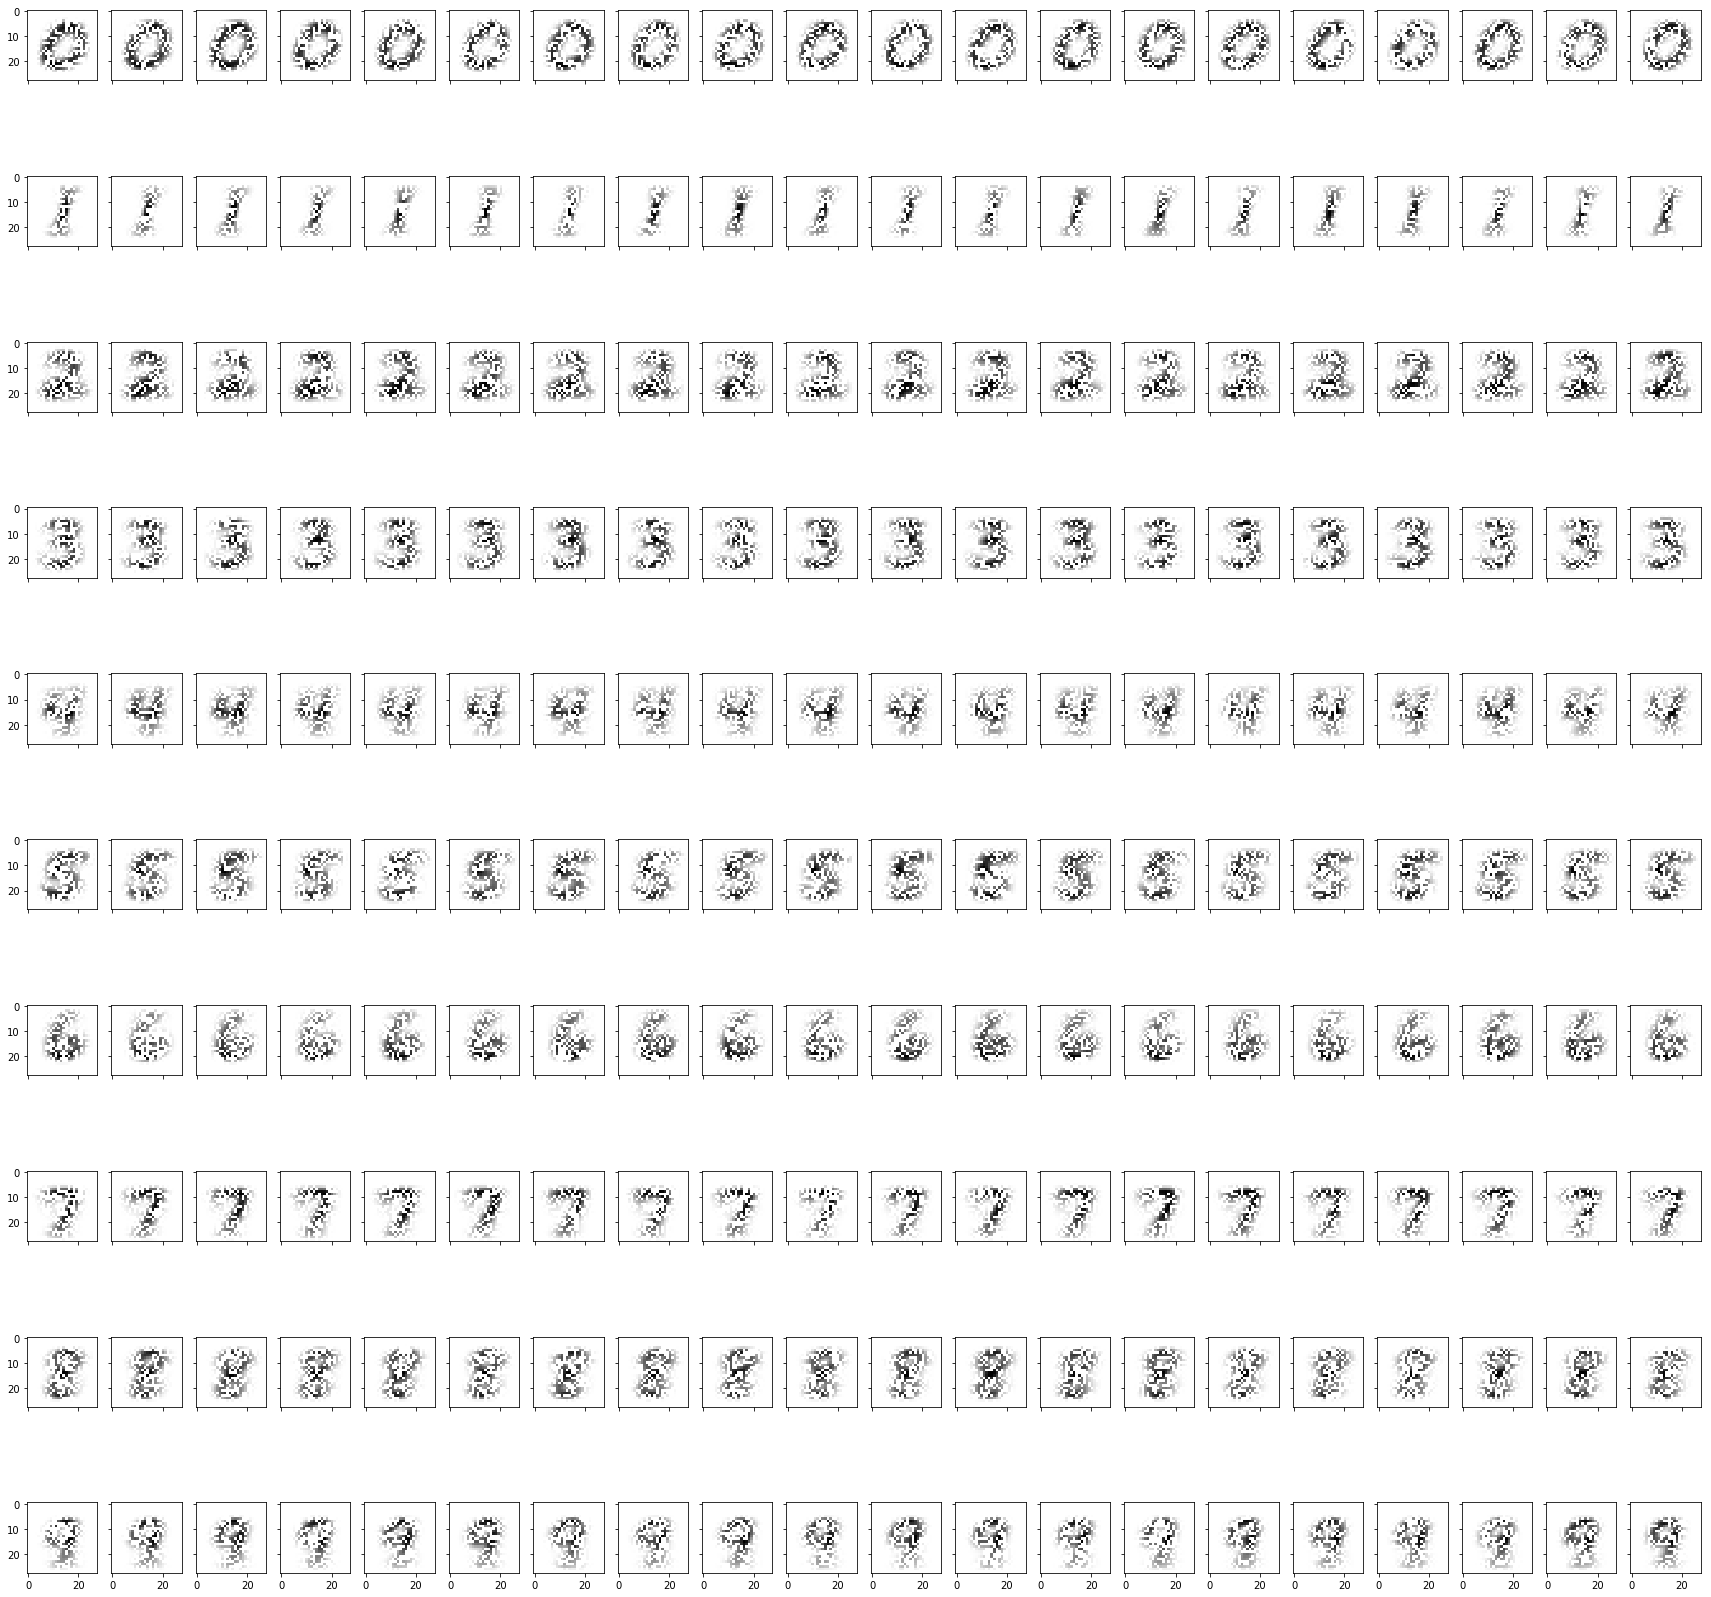

In [17]:
# Seeing the power of a generative model. 

cls = BernoulliNB()
cls.fit(train_data_Bernoulli, train_labels)

# Confirm the number of vectors. There seems to be 10 values. One for each number.
print len(cls.feature_log_prob_) 

# Graphing random variations of the number according to the feature probabilities
f, axarr = plt.subplots(10, 20, figsize=(30,30), sharex=True, sharey=True)

for x in range(0, len(cls.feature_log_prob_)):
    for i in range(0,20):
        
        bern_v = np.exp(cls.feature_log_prob_[x])
        
        #This part was tried with binary and non-binary numbers.
        # r_numb_v = np.random.rand(size=len(bern_v))
        r_numb_v = np.random.randint(2,size=len(bern_v))
        
        image_v = bern_v * r_numb_v
        
        digit = image_v.reshape(28,28)
        axarr[x, i].imshow(digit, cmap = matplotlib.cm.binary)

In [18]:
# Seeing how well calibrated the model is. Apparently calibrated means
# 90% accurate when the posterior probability of the predicted class is 0.9.
# Alpha was chosen because it seemed to work the best in part 8. 

# Training the model
cls = BernoulliNB(alpha = 0)

cls.fit(train_data_Bernoulli, train_labels)
predictions = cls.predict(dev_data_Bernoulli)


# Defining variables, counters, and initializing lists and dictionaries.  
buckets = [0.5, 0.9, 0.999, 0.99999, 0.9999999, 0.999999999, 0.99999999999, 0.9999999999999, 1.0]
buckets = sorted(buckets)

bucket_counter = {}
bucket_temp = []

for bucket in buckets:
    bucket_temp.append(bucket)
    bucket_counter[bucket] = {'correct':0, 'total':0}
    
# Updating the list and counters based on the prediction results  
for v, p, l in zip(cls.predict_proba(dev_data_Bernoulli), predictions, dev_labels):
    max_postprob = max(v)
    
    bucket_temp.append(max_postprob)
    #print(sorted(bucket_temp))
    position = sorted(bucket_temp).index(max_postprob)
    #print(sorted(bucket_temp).index(max_postprob))
    
    bucket_counter[float(buckets[position])]['total'] += 1
    
    if p == l: 
        bucket_counter[float(buckets[position])]['correct'] +=1 
    else:
        pass 
    
    bucket_temp.remove(max_postprob)
    #print(sorted(bucket_temp))
    
# Outputting the results   
for bucket, values in sorted(bucket_counter.items()):
    accuracy = round(float(values['correct'])/float(values['total']),2)
    print "Bucket:", bucket, "Total:", values['total'], "Correct:", values['correct'], "Accuracy:", accuracy

print("\nNote that the 0.9999999999999 bucket is being rounded to a 1. This is confirmed by looking at the original dictionary. There seems to be a 12 decimal limit in Python.\n")    
print(bucket_counter.items())

Bucket: 0.5 Total: 1 Correct: 1 Accuracy: 1.0
Bucket: 0.9 Total: 36 Correct: 11 Accuracy: 0.31
Bucket: 0.999 Total: 87 Correct: 44 Accuracy: 0.51
Bucket: 0.99999 Total: 88 Correct: 54 Accuracy: 0.61
Bucket: 0.9999999 Total: 67 Correct: 50 Accuracy: 0.75
Bucket: 0.999999999 Total: 70 Correct: 53 Accuracy: 0.76
Bucket: 0.99999999999 Total: 70 Correct: 61 Accuracy: 0.87
Bucket: 1.0 Total: 62 Correct: 56 Accuracy: 0.9
Bucket: 1.0 Total: 519 Correct: 510 Accuracy: 0.98

Note that the 0.9999999999999 bucket is being rounded to a 1. This is confirmed by looking at the original dictionary. There seems to be a 12 decimal limit in Python.

[(0.5, {'total': 1, 'correct': 1}), (1.0, {'total': 519, 'correct': 510}), (0.999, {'total': 87, 'correct': 44}), (0.9999999, {'total': 67, 'correct': 50}), (0.999999999, {'total': 70, 'correct': 53}), (0.9, {'total': 36, 'correct': 11}), (0.9999999999999, {'total': 62, 'correct': 56}), (0.99999, {'total': 88, 'correct': 54}), (0.99999999999, {'total': 70, 'co